# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter
import timm
#from torchvision.models import wide_resnet50_2, resnet18
#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import EfficientNet_b1 as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

In [4]:
model = timm.create_model('efficientnet_b1', pretrained=True)
#3, 320, 320
#name: (channel_multiplier, depth_multiplier, resolution, dropout_rate)
#(1.4, 1.8, 380, 0.4)

In [5]:
model.blocks[6][1].act1

SiLU(inplace=True)

## load config and set logger

In [6]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [7]:
# Setting seed
modeler.set_seed(42)

In [8]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_frame257/dcase2021_task2/config.yaml'

In [9]:
torch.cuda.is_available()

True

## make path list

- __train_paths__ ([dict]): Each Machine Type
    - __ToyCar__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) :paths
    - __ToyTrain__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) : paths
    - ...

In [10]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    print(f'Machine {machine_type}', end=',')
    print(f'dev_train_size : {len(dev_train_paths)}', end=', ')
    dev_train_source_paths = [path for path in dev_train_paths if 'source' in path]
    print(f'source_size : {len(dev_train_source_paths)}', end=', ')
    dev_train_target_paths = [path for path in dev_train_paths if 'target' in path]
    print(f'target_size : {len(dev_train_target_paths)}', end=', ')
    # source mode
    dev_train_paths = dev_train_source_paths
    
    # add_dev train
    add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    add_dev_paths = sorted(add_dev_paths)
    print(f'adddev_train_size : {len(dev_train_paths)}', end=', ')
    add_dev_source_paths = [path for path in add_dev_paths if 'source' in path]
    print(f'source_size : {len(add_dev_source_paths)}', end=', ')
    add_dev_target_paths = [path for path in add_dev_paths if 'target' in path]
    print(f'target_size : {len(add_dev_target_paths)}')
    # source mode
    add_dev_paths = add_dev_source_paths
    print('==============================================================')
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths + add_dev_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

Machine fan,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine gearbox,dev_train_size : 3026, source_size : 3017, target_size : 9, adddev_train_size : 3017, source_size : 3105, target_size : 9
Machine pump,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine slider,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine ToyCar,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine ToyTrain,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9
Machine valve,dev_train_size : 3009, source_size : 3000, target_size : 9, adddev_train_size : 3000, source_size : 3000, target_size : 9


## training

In [11]:
#############################################################################
# run
#############################################################################
def run_extract(machine_type, dev_paths):
    com.tic()
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(dev_paths, machine_type, mode='extract')
    # parameter setting
    logger.info('FEATURE EXTRACTION')
    net = Model(n_out=config['param']['mel_bins'])
    #optimizer = optim.Adam(net.parameters(), lr=config['param']['lr'])
    output_dicts = modeler.extract_net(net, dataloaders_dict)
    
    out_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    pd.to_pickle(output_dicts, out_path)
    logger.info(f'SAVE SUCCESS : {out_path}')
    
    com.toc()

In [12]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

# run

In [13]:
for machine_type in machine_types:
    run_extract(machine_type, dev_paths)

2021-08-11 12:52:32,051 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-08-11 12:52:32,052 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-11 12:52:32,053 - 00_train.py - INFO - FEATURE EXTRACTION


use: cuda:0


  0%|          | 0/24 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


  4%|▍         | 1/24 [00:04<01:45,  4.57s/it]

torch.Size([256, 3, 128, 501])


  8%|▊         | 2/24 [00:08<01:32,  4.19s/it]

torch.Size([256, 3, 128, 501])


 12%|█▎        | 3/24 [00:12<01:25,  4.09s/it]

torch.Size([256, 3, 128, 501])


 17%|█▋        | 4/24 [00:16<01:22,  4.11s/it]

torch.Size([256, 3, 128, 501])


 21%|██        | 5/24 [00:20<01:18,  4.12s/it]

torch.Size([256, 3, 128, 501])


 25%|██▌       | 6/24 [00:24<01:14,  4.16s/it]

torch.Size([256, 3, 128, 501])


 29%|██▉       | 7/24 [00:29<01:10,  4.15s/it]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 8/24 [00:33<01:06,  4.14s/it]

torch.Size([256, 3, 128, 501])


 38%|███▊      | 9/24 [00:37<01:02,  4.14s/it]

torch.Size([256, 3, 128, 501])


 42%|████▏     | 10/24 [00:41<00:57,  4.11s/it]

torch.Size([256, 3, 128, 501])


 46%|████▌     | 11/24 [00:45<00:53,  4.14s/it]

torch.Size([256, 3, 128, 501])


 50%|█████     | 12/24 [00:49<00:49,  4.15s/it]

torch.Size([256, 3, 128, 501])


 54%|█████▍    | 13/24 [00:53<00:45,  4.15s/it]

torch.Size([256, 3, 128, 501])


 58%|█████▊    | 14/24 [00:58<00:42,  4.20s/it]

torch.Size([256, 3, 128, 501])


 62%|██████▎   | 15/24 [01:02<00:38,  4.27s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 16/24 [01:06<00:33,  4.21s/it]

torch.Size([256, 3, 128, 501])


 71%|███████   | 17/24 [01:10<00:29,  4.19s/it]

torch.Size([256, 3, 128, 501])


 75%|███████▌  | 18/24 [01:15<00:25,  4.21s/it]

torch.Size([256, 3, 128, 501])


 79%|███████▉  | 19/24 [01:19<00:20,  4.18s/it]

torch.Size([256, 3, 128, 501])


 83%|████████▎ | 20/24 [01:23<00:16,  4.18s/it]

torch.Size([256, 3, 128, 501])


 88%|████████▊ | 21/24 [01:27<00:12,  4.18s/it]

torch.Size([256, 3, 128, 501])


 92%|█████████▏| 22/24 [01:31<00:08,  4.20s/it]

torch.Size([256, 3, 128, 501])


 96%|█████████▌| 23/24 [01:36<00:04,  4.21s/it]

torch.Size([112, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:03<00:06,  3.32s/it]

torch.Size([256, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([88, 3, 128, 501])
torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:03<00:06,  3.13s/it]

torch.Size([256, 3, 128, 501])


100%|██████████| 3/3 [00:07<00:00,  2.51s/it]

torch.Size([88, 3, 128, 501])



2021-08-11 12:54:28,891 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_frame257/dcase2021_task2/extraction_features/fan_features.pkl
2021-08-11 12:54:28,893 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-08-11 12:54:28,894 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-11 12:54:28,894 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/24 [00:00<?, ?it/s]

elapsed time: 118.114508867 [sec]
use: cuda:0
torch.Size([256, 3, 128, 501])


  4%|▍         | 1/24 [00:04<01:32,  4.02s/it]

torch.Size([256, 3, 128, 501])


  8%|▊         | 2/24 [00:08<01:34,  4.31s/it]

torch.Size([256, 3, 128, 501])


 12%|█▎        | 3/24 [00:12<01:28,  4.22s/it]

torch.Size([256, 3, 128, 501])


 17%|█▋        | 4/24 [00:16<01:23,  4.17s/it]

torch.Size([256, 3, 128, 501])


 21%|██        | 5/24 [00:20<01:17,  4.10s/it]

torch.Size([256, 3, 128, 501])


 25%|██▌       | 6/24 [00:24<01:13,  4.06s/it]

torch.Size([256, 3, 128, 501])


 29%|██▉       | 7/24 [00:28<01:08,  4.06s/it]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 8/24 [00:33<01:07,  4.22s/it]

torch.Size([256, 3, 128, 501])


 38%|███▊      | 9/24 [00:37<01:04,  4.30s/it]

torch.Size([256, 3, 128, 501])


 42%|████▏     | 10/24 [00:42<01:00,  4.31s/it]

torch.Size([256, 3, 128, 501])


 46%|████▌     | 11/24 [00:46<00:56,  4.32s/it]

torch.Size([256, 3, 128, 501])


 50%|█████     | 12/24 [00:50<00:51,  4.30s/it]

torch.Size([256, 3, 128, 501])


 54%|█████▍    | 13/24 [00:54<00:47,  4.27s/it]

torch.Size([256, 3, 128, 501])


 58%|█████▊    | 14/24 [00:59<00:42,  4.28s/it]

torch.Size([256, 3, 128, 501])


 62%|██████▎   | 15/24 [01:03<00:38,  4.29s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 16/24 [01:07<00:33,  4.24s/it]

torch.Size([256, 3, 128, 501])


 71%|███████   | 17/24 [01:11<00:29,  4.22s/it]

torch.Size([256, 3, 128, 501])


 75%|███████▌  | 18/24 [01:16<00:25,  4.22s/it]

torch.Size([256, 3, 128, 501])


 79%|███████▉  | 19/24 [01:20<00:21,  4.22s/it]

torch.Size([256, 3, 128, 501])


 83%|████████▎ | 20/24 [01:24<00:16,  4.20s/it]

torch.Size([256, 3, 128, 501])


 88%|████████▊ | 21/24 [01:28<00:12,  4.21s/it]

torch.Size([256, 3, 128, 501])


 92%|█████████▏| 22/24 [01:32<00:08,  4.20s/it]

torch.Size([256, 3, 128, 501])


 96%|█████████▌| 23/24 [01:37<00:04,  4.19s/it]

torch.Size([234, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:03<00:06,  3.16s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:06<00:03,  3.15s/it]

torch.Size([250, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:03<00:06,  3.46s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:07<00:03,  3.58s/it]

torch.Size([133, 3, 128, 501])


100%|██████████| 3/3 [00:09<00:00,  3.02s/it]
2021-08-11 12:56:28,829 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_frame257/dcase2021_task2/extraction_features/gearbox_features.pkl
2021-08-11 12:56:28,832 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-08-11 12:56:28,833 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-11 12:56:28,833 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/24 [00:00<?, ?it/s]

elapsed time: 119.937424183 [sec]
use: cuda:0
torch.Size([256, 3, 128, 501])


  4%|▍         | 1/24 [00:04<01:40,  4.35s/it]

torch.Size([256, 3, 128, 501])


  8%|▊         | 2/24 [00:09<01:42,  4.65s/it]

torch.Size([256, 3, 128, 501])


 12%|█▎        | 3/24 [00:13<01:33,  4.46s/it]

torch.Size([256, 3, 128, 501])


 17%|█▋        | 4/24 [00:17<01:27,  4.40s/it]

torch.Size([256, 3, 128, 501])


 21%|██        | 5/24 [00:22<01:22,  4.35s/it]

torch.Size([256, 3, 128, 501])


 25%|██▌       | 6/24 [00:26<01:17,  4.28s/it]

torch.Size([256, 3, 128, 501])


 29%|██▉       | 7/24 [00:30<01:12,  4.29s/it]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 8/24 [00:34<01:07,  4.21s/it]

torch.Size([256, 3, 128, 501])


 38%|███▊      | 9/24 [00:38<01:02,  4.16s/it]

torch.Size([256, 3, 128, 501])


 42%|████▏     | 10/24 [00:42<00:58,  4.16s/it]

torch.Size([256, 3, 128, 501])


 46%|████▌     | 11/24 [00:46<00:53,  4.12s/it]

torch.Size([256, 3, 128, 501])


 50%|█████     | 12/24 [00:50<00:49,  4.12s/it]

torch.Size([256, 3, 128, 501])


 54%|█████▍    | 13/24 [00:54<00:44,  4.08s/it]

torch.Size([256, 3, 128, 501])


 58%|█████▊    | 14/24 [00:58<00:40,  4.04s/it]

torch.Size([256, 3, 128, 501])


 62%|██████▎   | 15/24 [01:02<00:36,  4.05s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 16/24 [01:06<00:32,  4.05s/it]

torch.Size([256, 3, 128, 501])


 71%|███████   | 17/24 [01:11<00:28,  4.08s/it]

torch.Size([256, 3, 128, 501])


 75%|███████▌  | 18/24 [01:15<00:24,  4.08s/it]

torch.Size([256, 3, 128, 501])


 79%|███████▉  | 19/24 [01:19<00:20,  4.09s/it]

torch.Size([256, 3, 128, 501])


 83%|████████▎ | 20/24 [01:23<00:16,  4.11s/it]

torch.Size([256, 3, 128, 501])


 88%|████████▊ | 21/24 [01:27<00:12,  4.09s/it]

torch.Size([256, 3, 128, 501])


 92%|█████████▏| 22/24 [01:31<00:08,  4.08s/it]

torch.Size([256, 3, 128, 501])


 96%|█████████▌| 23/24 [01:35<00:04,  4.06s/it]

torch.Size([112, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:03<00:07,  3.60s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:07<00:03,  3.60s/it]

torch.Size([88, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:03<00:07,  3.53s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:06<00:03,  3.44s/it]

torch.Size([88, 3, 128, 501])


100%|██████████| 3/3 [00:08<00:00,  2.68s/it]
2021-08-11 12:58:23,391 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_frame257/dcase2021_task2/extraction_features/pump_features.pkl
2021-08-11 12:58:23,394 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-08-11 12:58:23,395 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-11 12:58:23,396 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/24 [00:00<?, ?it/s]

elapsed time: 114.560531616 [sec]
use: cuda:0
torch.Size([256, 3, 128, 501])


  4%|▍         | 1/24 [00:04<01:49,  4.75s/it]

torch.Size([256, 3, 128, 501])


  8%|▊         | 2/24 [00:09<01:49,  4.98s/it]

torch.Size([256, 3, 128, 501])


 12%|█▎        | 3/24 [00:14<01:43,  4.94s/it]

torch.Size([256, 3, 128, 501])


 17%|█▋        | 4/24 [00:19<01:37,  4.89s/it]

torch.Size([256, 3, 128, 501])


 21%|██        | 5/24 [00:24<01:31,  4.81s/it]

torch.Size([256, 3, 128, 501])


 25%|██▌       | 6/24 [00:28<01:25,  4.76s/it]

torch.Size([256, 3, 128, 501])


 29%|██▉       | 7/24 [00:33<01:19,  4.69s/it]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 8/24 [00:37<01:14,  4.63s/it]

torch.Size([256, 3, 128, 501])


 38%|███▊      | 9/24 [00:42<01:08,  4.54s/it]

torch.Size([256, 3, 128, 501])


 42%|████▏     | 10/24 [00:46<01:03,  4.54s/it]

torch.Size([256, 3, 128, 501])


 46%|████▌     | 11/24 [00:51<00:58,  4.51s/it]

torch.Size([256, 3, 128, 501])


 50%|█████     | 12/24 [00:55<00:53,  4.47s/it]

torch.Size([256, 3, 128, 501])


 54%|█████▍    | 13/24 [00:59<00:48,  4.40s/it]

torch.Size([256, 3, 128, 501])


 58%|█████▊    | 14/24 [01:04<00:43,  4.32s/it]

torch.Size([256, 3, 128, 501])


 62%|██████▎   | 15/24 [01:08<00:38,  4.31s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 16/24 [01:12<00:33,  4.25s/it]

torch.Size([256, 3, 128, 501])


 71%|███████   | 17/24 [01:16<00:29,  4.20s/it]

torch.Size([256, 3, 128, 501])


 75%|███████▌  | 18/24 [01:20<00:25,  4.19s/it]

torch.Size([256, 3, 128, 501])


 79%|███████▉  | 19/24 [01:24<00:20,  4.16s/it]

torch.Size([256, 3, 128, 501])


 83%|████████▎ | 20/24 [01:28<00:16,  4.12s/it]

torch.Size([256, 3, 128, 501])


 88%|████████▊ | 21/24 [01:32<00:12,  4.10s/it]

torch.Size([256, 3, 128, 501])


 92%|█████████▏| 22/24 [01:36<00:08,  4.10s/it]

torch.Size([256, 3, 128, 501])


 96%|█████████▌| 23/24 [01:41<00:04,  4.08s/it]

torch.Size([112, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:03<00:06,  3.26s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:06<00:03,  3.30s/it]

torch.Size([100, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:03<00:06,  3.48s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:07<00:03,  3.54s/it]

torch.Size([90, 3, 128, 501])


100%|██████████| 3/3 [00:08<00:00,  2.77s/it]
2021-08-11 13:00:23,043 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_frame257/dcase2021_task2/extraction_features/slider_features.pkl
2021-08-11 13:00:23,060 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-08-11 13:00:23,060 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-11 13:00:23,061 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 119.651154041 [sec]
use: cuda:0


  0%|          | 0/24 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


  4%|▍         | 1/24 [00:04<01:32,  4.02s/it]

torch.Size([256, 3, 128, 501])


  8%|▊         | 2/24 [00:08<01:37,  4.43s/it]

torch.Size([256, 3, 128, 501])


 12%|█▎        | 3/24 [00:12<01:30,  4.29s/it]

torch.Size([256, 3, 128, 501])


 17%|█▋        | 4/24 [00:16<01:23,  4.18s/it]

torch.Size([256, 3, 128, 501])


 21%|██        | 5/24 [00:20<01:18,  4.13s/it]

torch.Size([256, 3, 128, 501])


 25%|██▌       | 6/24 [00:24<01:13,  4.10s/it]

torch.Size([256, 3, 128, 501])


 29%|██▉       | 7/24 [00:29<01:09,  4.08s/it]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 8/24 [00:33<01:05,  4.10s/it]

torch.Size([256, 3, 128, 501])


 38%|███▊      | 9/24 [00:37<01:01,  4.09s/it]

torch.Size([256, 3, 128, 501])


 42%|████▏     | 10/24 [00:41<00:57,  4.11s/it]

torch.Size([256, 3, 128, 501])


 46%|████▌     | 11/24 [00:45<00:53,  4.09s/it]

torch.Size([256, 3, 128, 501])


 50%|█████     | 12/24 [00:49<00:49,  4.10s/it]

torch.Size([256, 3, 128, 501])


 54%|█████▍    | 13/24 [00:53<00:44,  4.06s/it]

torch.Size([256, 3, 128, 501])


 58%|█████▊    | 14/24 [00:57<00:40,  4.06s/it]

torch.Size([256, 3, 128, 501])


 62%|██████▎   | 15/24 [01:01<00:36,  4.04s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 16/24 [01:05<00:32,  4.05s/it]

torch.Size([256, 3, 128, 501])


 71%|███████   | 17/24 [01:09<00:28,  4.02s/it]

torch.Size([256, 3, 128, 501])


 75%|███████▌  | 18/24 [01:13<00:23,  3.98s/it]

torch.Size([256, 3, 128, 501])


 79%|███████▉  | 19/24 [01:17<00:19,  3.96s/it]

torch.Size([256, 3, 128, 501])


 83%|████████▎ | 20/24 [01:21<00:15,  3.94s/it]

torch.Size([256, 3, 128, 501])


 88%|████████▊ | 21/24 [01:25<00:11,  3.95s/it]

torch.Size([256, 3, 128, 501])


 92%|█████████▏| 22/24 [01:29<00:07,  3.94s/it]

torch.Size([256, 3, 128, 501])


 96%|█████████▌| 23/24 [01:33<00:03,  3.94s/it]

torch.Size([112, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:03<00:07,  3.56s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:07<00:03,  3.56s/it]

torch.Size([88, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:03<00:06,  3.45s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:06<00:03,  3.48s/it]

torch.Size([88, 3, 128, 501])


100%|██████████| 3/3 [00:08<00:00,  2.72s/it]
2021-08-11 13:02:15,025 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_frame257/dcase2021_task2/extraction_features/ToyCar_features.pkl
2021-08-11 13:02:15,041 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-08-11 13:02:15,042 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-11 13:02:15,043 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/24 [00:00<?, ?it/s]

elapsed time: 111.993352175 [sec]
use: cuda:0
torch.Size([256, 3, 128, 501])


  4%|▍         | 1/24 [00:04<01:45,  4.60s/it]

torch.Size([256, 3, 128, 501])


  8%|▊         | 2/24 [00:09<01:50,  5.02s/it]

torch.Size([256, 3, 128, 501])


 12%|█▎        | 3/24 [00:14<01:42,  4.88s/it]

torch.Size([256, 3, 128, 501])


 17%|█▋        | 4/24 [00:19<01:35,  4.79s/it]

torch.Size([256, 3, 128, 501])


 21%|██        | 5/24 [00:23<01:28,  4.66s/it]

torch.Size([256, 3, 128, 501])


 25%|██▌       | 6/24 [00:28<01:21,  4.55s/it]

torch.Size([256, 3, 128, 501])


 29%|██▉       | 7/24 [00:32<01:15,  4.47s/it]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 8/24 [00:36<01:10,  4.38s/it]

torch.Size([256, 3, 128, 501])


 38%|███▊      | 9/24 [00:40<01:04,  4.29s/it]

torch.Size([256, 3, 128, 501])


 42%|████▏     | 10/24 [00:44<00:59,  4.22s/it]

torch.Size([256, 3, 128, 501])


 46%|████▌     | 11/24 [00:48<00:53,  4.13s/it]

torch.Size([256, 3, 128, 501])


 50%|█████     | 12/24 [00:52<00:48,  4.05s/it]

torch.Size([256, 3, 128, 501])


 54%|█████▍    | 13/24 [00:56<00:44,  4.06s/it]

torch.Size([256, 3, 128, 501])


 58%|█████▊    | 14/24 [01:00<00:40,  4.06s/it]

torch.Size([256, 3, 128, 501])


 62%|██████▎   | 15/24 [01:04<00:36,  4.04s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 16/24 [01:08<00:32,  4.06s/it]

torch.Size([256, 3, 128, 501])


 71%|███████   | 17/24 [01:12<00:28,  4.02s/it]

torch.Size([256, 3, 128, 501])


 75%|███████▌  | 18/24 [01:16<00:24,  4.02s/it]

torch.Size([256, 3, 128, 501])


 79%|███████▉  | 19/24 [01:20<00:20,  4.02s/it]

torch.Size([256, 3, 128, 501])


 83%|████████▎ | 20/24 [01:24<00:16,  4.03s/it]

torch.Size([256, 3, 128, 501])


 88%|████████▊ | 21/24 [01:28<00:11,  3.99s/it]

torch.Size([256, 3, 128, 501])


 92%|█████████▏| 22/24 [01:32<00:08,  4.01s/it]

torch.Size([256, 3, 128, 501])


 96%|█████████▌| 23/24 [01:36<00:03,  4.00s/it]

torch.Size([112, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:02<00:05,  2.65s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:05<00:02,  2.62s/it]

torch.Size([88, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:02<00:05,  2.59s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:05<00:02,  2.73s/it]

torch.Size([88, 3, 128, 501])


100%|██████████| 3/3 [00:06<00:00,  2.17s/it]
2021-08-11 13:04:06,788 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_frame257/dcase2021_task2/extraction_features/ToyTrain_features.pkl
2021-08-11 13:04:06,791 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-08-11 13:04:06,792 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-11 13:04:06,792 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/24 [00:00<?, ?it/s]

elapsed time: 111.748438358 [sec]
use: cuda:0
torch.Size([256, 3, 128, 501])


  4%|▍         | 1/24 [00:04<01:52,  4.87s/it]

torch.Size([256, 3, 128, 501])


  8%|▊         | 2/24 [00:10<01:54,  5.22s/it]

torch.Size([256, 3, 128, 501])


 12%|█▎        | 3/24 [00:15<01:46,  5.09s/it]

torch.Size([256, 3, 128, 501])


 17%|█▋        | 4/24 [00:20<01:39,  4.96s/it]

torch.Size([256, 3, 128, 501])


 21%|██        | 5/24 [00:24<01:30,  4.78s/it]

torch.Size([256, 3, 128, 501])


 25%|██▌       | 6/24 [00:28<01:24,  4.68s/it]

torch.Size([256, 3, 128, 501])


 29%|██▉       | 7/24 [00:33<01:17,  4.56s/it]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 8/24 [00:37<01:09,  4.36s/it]

torch.Size([256, 3, 128, 501])


 38%|███▊      | 9/24 [00:41<01:04,  4.29s/it]

torch.Size([256, 3, 128, 501])


 42%|████▏     | 10/24 [00:45<00:59,  4.22s/it]

torch.Size([256, 3, 128, 501])


 46%|████▌     | 11/24 [00:49<00:53,  4.13s/it]

torch.Size([256, 3, 128, 501])


 50%|█████     | 12/24 [00:53<00:48,  4.04s/it]

torch.Size([256, 3, 128, 501])


 54%|█████▍    | 13/24 [00:57<00:44,  4.01s/it]

torch.Size([256, 3, 128, 501])


 58%|█████▊    | 14/24 [01:01<00:39,  3.98s/it]

torch.Size([256, 3, 128, 501])


 62%|██████▎   | 15/24 [01:05<00:35,  3.98s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 16/24 [01:09<00:31,  3.99s/it]

torch.Size([256, 3, 128, 501])


 71%|███████   | 17/24 [01:12<00:27,  3.97s/it]

torch.Size([256, 3, 128, 501])


 75%|███████▌  | 18/24 [01:16<00:23,  3.98s/it]

torch.Size([256, 3, 128, 501])


 79%|███████▉  | 19/24 [01:21<00:20,  4.01s/it]

torch.Size([256, 3, 128, 501])


 83%|████████▎ | 20/24 [01:25<00:16,  4.02s/it]

torch.Size([256, 3, 128, 501])


 88%|████████▊ | 21/24 [01:28<00:11,  3.97s/it]

torch.Size([256, 3, 128, 501])


 92%|█████████▏| 22/24 [01:32<00:07,  3.97s/it]

torch.Size([256, 3, 128, 501])


 96%|█████████▌| 23/24 [01:36<00:03,  3.95s/it]

torch.Size([112, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:02<00:05,  2.63s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:05<00:02,  2.68s/it]

torch.Size([88, 3, 128, 501])


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([256, 3, 128, 501])


 33%|███▎      | 1/3 [00:02<00:05,  2.59s/it]

torch.Size([256, 3, 128, 501])


 67%|██████▋   | 2/3 [00:05<00:02,  2.61s/it]

torch.Size([88, 3, 128, 501])


100%|██████████| 3/3 [00:06<00:00,  2.03s/it]
2021-08-11 13:05:58,401 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet_frame257/dcase2021_task2/extraction_features/valve_features.pkl


elapsed time: 111.612625599 [sec]


In [14]:
machine_type = 'fan'
input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
ext_data = pd.read_pickle(input_path)

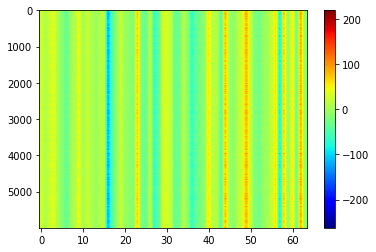

In [15]:
plt.imshow(ext_data['train']['features'][:,:64], cmap='jet', aspect='auto')
plt.colorbar()

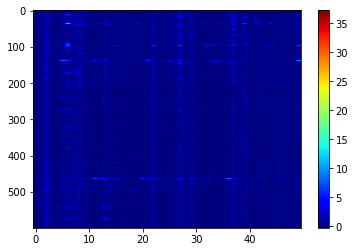

In [16]:
plt.imshow(ext_data['valid_source']['features'][:,2050:2100], cmap='jet', aspect='auto')
plt.colorbar()

In [17]:
ext_data['valid_source']['features'].shape

(600, 3024)